# Project : Tayara-Cars Prediction

## Import libraries

In [979]:
import math
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import cm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures

from sklearn import tree   
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

import datetime
date = datetime.datetime.today()

## support functions

In [980]:
def plot_correlation_map(df):
    corr = df.corr()
    s , ax = plt.subplots(figsize=(12,10))
    cmap = sb.diverging_palette(220,10,as_cmap = True)
    s = sb.heatmap(corr,cmap = cmap,square=True,cbar_kws={ 'shrink' : .9 },ax=ax,
                   annot = True,annot_kws = { 'fontsize' : 12 })

In [981]:
def gouv_name(location):
    gouv = location.split(',')
    return gouv[0]

In [982]:
def price_rec(pr):
    ch = str(int(pr))
    if len(ch)<3:
        pr = pr*1000
    if len(ch)==3:
        pr = 100*pr
    return pr

In [983]:
def annee_rec(an):
    an = int(abs(an))
    if ((an < 22) & (an >= 0)):
        return int(an+2000)   
    elif ((an >= 80) & (an < 100)):
        return int(an+1900)
    elif ((an>=1970) & (an<=date.year)):
        return int(an)
    else:
        return math.nan
        

In [984]:
def km_rec(km):
    ch =''
    km = round(abs(km))
    ch = str(km)
    if len(ch)>=7:
        res = int(ch[:6]) 
        return res
    elif ((len(ch)>=4) & (len(ch)<=6)):
        res = abs(km)
        return res
    elif ((len(ch) >= 1) & (len(ch)<=3)):
        res= abs(km)*1000
        return res

In [985]:
def puissance_rec(ch):
    ch = int(ch)
    cv = []
    if (ch < 600) & (ch > 25): # convert ch (puissance) in cv (chevaux fiscaux)
        CO2=110 # mean CO2 value in [gr/km] 
        cv = round((CO2/45) + (0.736*ch/40)*1.6)
    if (ch>0) & (ch<26):
        cv = ch
    if (ch>=600) or (ch<=1):
        cv = math.nan
    return cv

In [992]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10722 entries, 0 to 10729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  10722 non-null  int64  
 1   location    10722 non-null  object 
 2   km          10722 non-null  float64
 3   annee       10722 non-null  object 
 4   marque      10722 non-null  object 
 5   model       10722 non-null  object 
 6   date        10722 non-null  object 
 7   price       10722 non-null  float64
 8   carburant   10722 non-null  object 
 9   puissance   10722 non-null  object 
 10  boite       10722 non-null  object 
 11  cylindre    10722 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 1.4+ MB


## Import and explore data

In [994]:
path = 'C:\\Users\\omarb\\Documents\\Introduction to AI\\Jupyter\\Datasets\\'
df = pd.read_csv(path+"tayara_cars.csv",sep=',',skipinitialspace=True)
df.head(10)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10730 entries, 0 to 10729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  10730 non-null  int64  
 1   location    10730 non-null  object 
 2   km          10723 non-null  float64
 3   annee       10728 non-null  object 
 4   marque      10728 non-null  object 
 5   model       10727 non-null  object 
 6   date        10730 non-null  object 
 7   price       10725 non-null  float64
 8   carburant   10727 non-null  object 
 9   puissance   10727 non-null  object 
 10  boite       10727 non-null  object 
 11  cylindre    10727 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 1006.1+ KB


In [995]:
df

,Unnamed: 0,location,km,annee,marque,model,date,price,carburant,puissance,boite,cylindre
0,0,"Ben arous, Ezzahra",1.0,2021,Volkswagen,Polo,14 mars 2021,12500.0,Diesel,4,Jaune,Compacte
1,1,"Tunis, Tunis",180000.0,2008,Opel,Astra,14 mars 2021,21500.0,Diesel,1,Noir,Berline
2,2,"Ben arous, Ezzahra",1.0,2021,Volkswagen,Polo,14 mars 2021,12500.0,Diesel,4,Jaune,Compacte
3,3,"Tunis, Tunis",180000.0,2008,Opel,Astra,14 mars 2021,21500.0,Diesel,1,Noir,Berline
4,4,"Monastir, Autres villes",200000.0,1999,Renault,12,14 mars 2021,111111.0,Essence,4,Blanc,Autres
...,...,...,...,...,...,...,...,...,...,...,...,...
10725,10725,"Ben arous, Radès",86000.0,2013,Peugeot,208,6 février 2021,28800.0,Essence,5,Bleu,Compacte
10726,10726,"Gafsa, Redeyef",232000.0,2009,Renault,Megane,6 février 2021,23500.0,Essence,6,Noir,Berline
10727,10727,"Sfax, Sfax Médina",101000.0,2015,Kia,Rio,6 février 2021,37500.0,Essence,5,Noir,Berline
10728,10728,"Tataouine, Tataouine",273000.0,2008,Volkswagen,Passat,6 février 2021,29000.0,Essence,7,Noir,Autres


In [996]:
df.isnull().sum()

Unnamed: 0    0
location      0
km            7
annee         2
marque        2
model         3
date          0
price         5
carburant     3
puissance     3
boite         3
cylindre      3
dtype: int64

In [997]:
df = df.dropna(axis=0,how='any')

In [998]:
df.km.unique()[df.km.unique()<10]

array([ 1.00e+00,  0.00e+00,  2.00e+00,  8.00e+00,  3.00e+00,  5.00e+00,
       -1.00e+00,  7.00e+00,  4.00e+00, -1.88e+05, -3.74e+05, -1.30e+05,
        9.00e+00, -1.50e+02, -1.20e+02])

In [999]:
# Check if the price is not in dinar (thousands of dinar)
df.price.unique()[df.price.unique()<1000]

array([ 32.,  62.,  23., 500.,  34.,  26.,  39.,  15.,  25.,   6.,  52.,
        47.,  36.,  24.,  11.,  31.,  20.,  30.,  10., 123.,  37., 263.,
        49.,  35.,  64.,  21.,  13.,  29.,  27.,  22.,  19.,  45., 350.,
        50.,  33.,  17.,  53.,  69.,  88.,   9.,  65.,  60.,  80., 200.,
        55.,  12.,  16.,  40.,  87.,  46., 110., 120.,  38., 112., 400.,
       105., 777.,  71.,  18.,  59., 250.,  14., 220.,  61.,  66.,   7.,
       111., 109., 650.,  68.,  56.,   5.,  70.,  95., 950.,  44.,  41.,
        28.,  90., 163., 680., 850., 125., 300., 128., 450., 100.,  43.,
        42., 130., 165., 750., 470., 370., 700.,  58.,  99., 158., 170.,
       114.,  89., 320.,  63., 600., 800.,  82., 150.,  85.,  96., 520.,
       180., 260., 550.,  72.,  74.,  77.,  54., 160.,  83.,  57., 580.,
         8., 148., 155., 420., 222.,  67.,  78., 140.,  98., 108., 380.,
       118.,  48., 197., 185., 290., 900., 208.,  51., 126.,  75., 330.,
       135., 210., 360., 999., 138., 230.,  79., 22

Some price entries are in ten thousand dinars (ex: 25 -> 25000)
Others are misspelled (0 is extra or missing)

In [1000]:
df.annee.unique()
print('ANNEE unique values:',df.annee.unique())

ANNEE unique values: ['2021' '2008' '1999' '2019' '2013' '2009' '2000' '2012' '2010' '2004'
 '2016' '2002' '1997' '89' '2011' '2005' '5000' '2014' '1880' '1996'
 '2018' '1992' '1987' '2001' '2015' '2007' '112019' '2003' '2017' '1998'
 '2020' '216' '1984' '1994' '1991' '1985' '1986' '1993' '2222' '1995' '97'
 '2006' '25072018' '98984991' '1988' '1977' '10' '1990' '1982' '0' '207'
 '12222' '86' '1989' '9' '555' '88' '222222' '8' '1983' '1981' '66' '96'
 '2222222' '68' '123' '1' '11111' 'BMW' '211' '87' '13' '95' '1111' '98'
 '93835898' '111111' '1979' '1978' '93' '90' '92' '11' '1980' '213' '1900'
 '47' '9999' '20000' '1000' '99713043' '766' '200000' '19998' '7' '122006'
 '111' '5' '94' '20' '1950' '2' '101' '1960' '75000' '111112' '85' '1969'
 '25' '999' '12' '200' '95063694' '102019' '203' '199' '1111111' '201'
 '1222' '51056308' '99999' '19999' '90555' '1975' '872772' '27' '91' '116'
 '75' '199999999' '209' '897900' '202' '18' '50' '222' '78' '79' '99' '14'
 '-1' '45' '-1999' '23' '82

*Annee* data is very messed, but we can use the data inside *date*, which seems clean.

In [1001]:
print('DATE unique values:',df.date.unique())
print('NaNs: ',df.date.isnull().sum())

DATE unique values: ['14 mars 2021' '13 mars 2021' '12 mars 2021' '11 mars 2021'
 '10 mars 2021' '9 mars 2021' '8 mars 2021' '7 mars 2021' '6 mars 2021'
 '5 mars 2021' '4 mars 2021' '3 mars 2021' '2 mars 2021' '1 mars 2021'
 '28 février 2021' '27 février 2021' '26 février 2021' '25 février 2021'
 '24 février 2021' '23 février 2021' '22 février 2021' '21 février 2021'
 '20 février 2021' '19 février 2021' '18 février 2021' '17 février 2021'
 '16 février 2021' '15 février 2021' '14 février 2021' '13 février 2021'
 '12 février 2021' '11 février 2021' '10 février 2021' '9 février 2021'
 '8 février 2021' '7 février 2021' '6 février 2021']
NaNs:  0


clearly this date refers to when the offer was inserted in Tayara, not the date of acquisition of the car. Thus it is not a very important information

In [1002]:
df

,Unnamed: 0,location,km,annee,marque,model,date,price,carburant,puissance,boite,cylindre
0,0,"Ben arous, Ezzahra",1.0,2021,Volkswagen,Polo,14 mars 2021,12500.0,Diesel,4,Jaune,Compacte
1,1,"Tunis, Tunis",180000.0,2008,Opel,Astra,14 mars 2021,21500.0,Diesel,1,Noir,Berline
2,2,"Ben arous, Ezzahra",1.0,2021,Volkswagen,Polo,14 mars 2021,12500.0,Diesel,4,Jaune,Compacte
3,3,"Tunis, Tunis",180000.0,2008,Opel,Astra,14 mars 2021,21500.0,Diesel,1,Noir,Berline
4,4,"Monastir, Autres villes",200000.0,1999,Renault,12,14 mars 2021,111111.0,Essence,4,Blanc,Autres
...,...,...,...,...,...,...,...,...,...,...,...,...
10725,10725,"Ben arous, Radès",86000.0,2013,Peugeot,208,6 février 2021,28800.0,Essence,5,Bleu,Compacte
10726,10726,"Gafsa, Redeyef",232000.0,2009,Renault,Megane,6 février 2021,23500.0,Essence,6,Noir,Berline
10727,10727,"Sfax, Sfax Médina",101000.0,2015,Kia,Rio,6 février 2021,37500.0,Essence,5,Noir,Berline
10728,10728,"Tataouine, Tataouine",273000.0,2008,Volkswagen,Passat,6 février 2021,29000.0,Essence,7,Noir,Autres


## Preprocess

In [1003]:
#work on a copy of the original dataset
data = df
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10722 entries, 0 to 10729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  10722 non-null  int64  
 1   location    10722 non-null  object 
 2   km          10722 non-null  float64
 3   annee       10722 non-null  object 
 4   marque      10722 non-null  object 
 5   model       10722 non-null  object 
 6   date        10722 non-null  object 
 7   price       10722 non-null  float64
 8   carburant   10722 non-null  object 
 9   puissance   10722 non-null  object 
 10  boite       10722 non-null  object 
 11  cylindre    10722 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 1.1+ MB


In [1004]:
# drop first unused column
data = data.drop('Unnamed: 0',axis=1)

In [1006]:
# rename column
data.rename(columns={'boite':'couleur'},inplace=True)
data.couleur.unique()

array(['Jaune', 'Noir', 'Blanc', 'Nouveau', 'Marron', 'Gris', 'Bleu',
       'Beige', 'Manuelle', 'Argent', 'Rouge', 'Vert', 'Camel',
       'Avec kilométrage', 'Autre', 'Doré', 'Berline', '4 x 4', 'Corail',
       'Automatique', 'Violet', 'Orange', 'Autres', 'Multicolore',
       'Utilitaire', 'Compacte', 'Cabriolet', 'Monospace', 'RS',
       'Pick up', 'Rose', 'Pièces manquantes'], dtype=object)

In [1007]:
# replace non color items with NaNs
dict_couleur={'Nouveau':math.nan,'Manuelle':math.nan,
       'Avec kilométrage':math.nan, 'Autre':math.nan, 'Berline':math.nan, '4 x 4':math.nan,
       'Automatique':math.nan,'Autres':math.nan,
       'Utilitaire':math.nan, 'Compacte':math.nan, 'Cabriolet':math.nan, 'Monospace':math.nan, 'RS':math.nan,
        'Pick up':math.nan, 'Pièces manquantes':math.nan}
data.couleur=data['couleur'].replace(dict_couleur) 
data.couleur.fillna(data.couleur.mode()[0],inplace=True)

In [1008]:
# Check 
data.couleur.unique()

array(['Jaune', 'Noir', 'Blanc', 'Marron', 'Gris', 'Bleu', 'Beige',
       'Argent', 'Rouge', 'Vert', 'Camel', 'Doré', 'Corail', 'Violet',
       'Orange', 'Multicolore', 'Rose'], dtype=object)

In [1009]:
# extract city name and drop location
data.location=data['location'].map(gouv_name,na_action='ignore')
data.location.fillna(data.location.mode()[0],inplace=True)

In [1010]:
#data["type"] = data["cylindre"].astype("category")

In [1011]:
# drop a wrong entry
data = data.drop(data[data['annee']=='BMW'].index,axis=0)

In [1012]:
# Handle horse power data
#data.puissance.convert_dtypes(convert_integer=True)
data.puissance=pd.to_numeric(data.puissance,errors='coerce')
data.dropna(axis=0, how='any', thresh=None, subset=['puissance'], inplace=True)
data.puissance=data['puissance'].map(puissance_rec,na_action='ignore')
data.dropna(axis=0, how='any', thresh=None, subset=['puissance'], inplace=True)

In [1013]:
data.puissance.describe()

count    10131.000000
mean         6.270358
std          2.489990
min          2.000000
25%          5.000000
50%          6.000000
75%          7.000000
max         25.000000
Name: puissance, dtype: float64

[Text(0.5, 0, 'puissance in CH'), Text(0.5, 1.0, 'boxplot')]

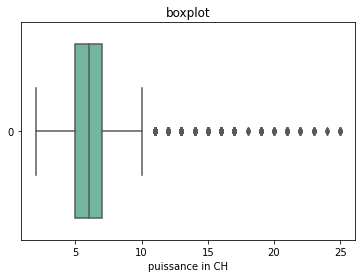

In [1014]:
ax = sb.boxplot(data=data['puissance'],orient='h',palette='Set2')
ax.set(xlabel='puissance in CH',title='boxplot')

In [1015]:
data['annee']=data['annee'].astype(int)

[Text(0.5, 0, 'annee'), Text(0.5, 1.0, 'boxplot')]

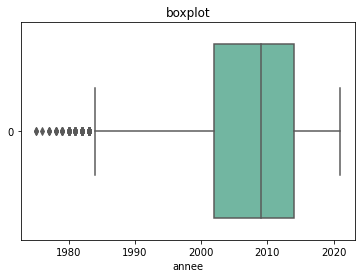

In [1016]:
# Handle year data
data['annee']=data['annee'].map(annee_rec,na_action='ignore')
data.fillna(round(data['annee'].mean()), inplace=True)

ax = sb.boxplot(data=data['annee'],orient='h',palette='Set2')
ax.set(xlabel='annee',title='boxplot')

In [1017]:
# Handle price 
data['price'].map(price_rec,na_action='ignore')
data.dropna(axis=0, how='any', thresh=None, subset=['price'], inplace=True)

[Text(0.5, 0, 'price'), Text(0.5, 1.0, 'boxplot')]

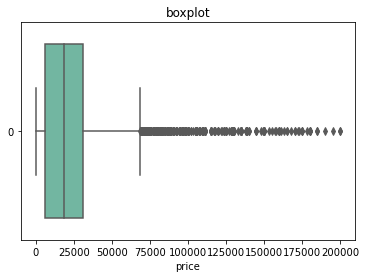

In [1018]:
ax = sb.boxplot(data=data['price'],orient='h',palette='Set2')
ax.set(xlabel='price',title='boxplot')

In [1019]:
# Handle km 
data['km']=data['km'].map(km_rec,na_action='ignore')

[Text(0.5, 0, 'km'), Text(0.5, 1.0, 'boxplot')]

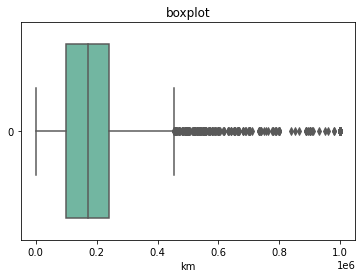

In [1020]:
ax = sb.boxplot(data=data['km'],orient='h',palette='Set2')
ax.set(xlabel='km',title='boxplot')

In [1021]:
data.km.describe()

count     10131.000000
mean     180551.484059
std      132462.629165
min           0.000000
25%       98000.000000
50%      170000.000000
75%      240000.000000
max      999999.000000
Name: km, dtype: float64

In [1022]:
data.isnull().sum()

location     0
km           0
annee        0
marque       0
model        0
date         0
price        0
carburant    0
puissance    0
couleur      0
cylindre     0
dtype: int64

In [1023]:
# take logical values
mask=data.km >= 600000
data.drop(data[mask].index, inplace=True)

In [1024]:
data

,location,km,annee,marque,model,date,price,carburant,puissance,couleur,cylindre
0,Ben arous,1000,2021.0,Volkswagen,Polo,14 mars 2021,12500.0,Diesel,4.0,Jaune,Compacte
2,Ben arous,1000,2021.0,Volkswagen,Polo,14 mars 2021,12500.0,Diesel,4.0,Jaune,Compacte
4,Monastir,200000,1999.0,Renault,12,14 mars 2021,111111.0,Essence,4.0,Blanc,Autres
5,Tunis,29000,2019.0,Volkswagen,Polo,14 mars 2021,45000.0,Essence,5.0,Blanc,Manuelle
6,Tunis,122000,2013.0,Peugeot,208,13 mars 2021,26800.0,Essence,5.0,Marron,Compacte
...,...,...,...,...,...,...,...,...,...,...,...
10725,Ben arous,86000,2013.0,Peugeot,208,6 février 2021,28800.0,Essence,5.0,Bleu,Compacte
10726,Gafsa,232000,2009.0,Renault,Megane,6 février 2021,23500.0,Essence,6.0,Noir,Berline
10727,Sfax,101000,2015.0,Kia,Rio,6 février 2021,37500.0,Essence,5.0,Noir,Berline
10728,Tataouine,273000,2008.0,Volkswagen,Passat,6 février 2021,29000.0,Essence,7.0,Noir,Autres


In [1025]:
data.describe()

,km,annee,price,puissance
count,9997.000000,9997.000000,9997.000000,9997.000000
mean,172152.161248,2007.522157,22734.587576,6.261178
std,110214.642691,8.556011,23536.191952,2.473935
min,0.000000,1975.000000,5.000000,2.000000
25%,96700.000000,2002.000000,6000.000000,5.000000
50%,168000.000000,2010.000000,18500.000000,6.000000
75%,240000.000000,2014.000000,31500.000000,7.000000
max,592783.000000,2021.000000,200000.000000,25.000000


In [1026]:
newCols = {'km':'km','annee':'year','marque':'brand','carburant':'Fuel_Type','couleur':'Color','puissance':'Horse_pow','cylindre':'type'}
data.rename(columns=newCols, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9997 entries, 0 to 10729
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   location   9997 non-null   object 
 1   km         9997 non-null   int64  
 2   year       9997 non-null   float64
 3   brand      9997 non-null   object 
 4   model      9997 non-null   object 
 5   date       9997 non-null   object 
 6   price      9997 non-null   float64
 7   Fuel_Type  9997 non-null   object 
 8   Horse_pow  9997 non-null   float64
 9   Color      9997 non-null   object 
 10  type       9997 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 937.2+ KB


In [1027]:
data['Current Year']=2021
data['nb_year']=data['Current Year']- data['year']
data=data.drop(['Current Year'],axis=1)

In [1028]:
data.describe()

,km,year,price,Horse_pow,nb_year
count,9997.000000,9997.000000,9997.000000,9997.000000,9997.000000
mean,172152.161248,2007.522157,22734.587576,6.261178,13.477843
std,110214.642691,8.556011,23536.191952,2.473935,8.556011
min,0.000000,1975.000000,5.000000,2.000000,0.000000
25%,96700.000000,2002.000000,6000.000000,5.000000,7.000000
50%,168000.000000,2010.000000,18500.000000,6.000000,11.000000
75%,240000.000000,2014.000000,31500.000000,7.000000,19.000000
max,592783.000000,2021.000000,200000.000000,25.000000,46.000000


In [1029]:
# location encoding
locations = data.location.unique()
code = list(range(1,len(locations)+1))
loc_dict = dict(zip(locations,code))
loc_dict = {'location':loc_dict}
data.replace(loc_dict,inplace=True)
data
print(loc_dict)

{'location': {'Ben arous': 1, 'Monastir': 2, 'Tunis': 3, 'Sfax': 4, 'Nabeul': 5, 'Sousse': 6, 'Ariana': 7, 'Zaghouan': 8, 'Bizerte': 9, 'Siliana': 10, 'Gafsa': 11, 'Le kef': 12, 'Tataouine': 13, 'Jendouba': 14, 'Médenine': 15, 'Béja': 16, 'Kairouan': 17, 'La manouba': 18, 'Gabès': 19, 'Kébili': 20, 'Sidi bouzid': 21, 'Mahdia': 22, 'Tozeur': 23, 'Kasserine': 24}}


In [1030]:
# Brand encoding
brands = data.brand.unique()
code = list(range(1,len(brands)+1))
brand_dict = dict(zip(brands,code))
brand_dict = {'brand':brand_dict}
data.replace(brand_dict,inplace=True)
data
print(brand_dict)

{'brand': {'Volkswagen': 1, 'Renault': 2, 'Peugeot': 3, 'BMW': 4, 'Isuzu': 5, 'Nissan': 6, 'Citroen': 7, 'Mercedes-Benz': 8, 'Fiat': 9, 'Ford': 10, 'Mazda': 11, 'Hyundai': 12, 'Mitsubishi': 13, 'Audi': 14, 'Seat': 15, 'Chevrolet': 16, 'Chery': 17, 'Kia': 18, 'Opel': 19, 'Toyota': 20, 'Suzuki': 21, 'Ssangyong': 22, 'Iveco': 23, 'Autres': 24, 'Acrea': 25, 'Skoda': 26, 'AC': 27, 'Jeep': 28, 'Smart': 29, 'Dacia': 30, 'Land Rover': 31, 'Mahindra': 32, 'Porsche': 33, 'Daihatsu': 34, 'mini': 35, 'Honda': 36, 'Alfa Romeo': 37, 'Daewoo': 38, 'Volvo': 39, 'Jaguar': 40, 'Dodge': 41, 'UFO': 42, 'Masey Ferguson': 43, 'Aston Martin': 44, 'Changhe': 45, 'Cadillac': 46, 'Geely': 47, 'Man': 48, 'lancia': 49, 'Infiniti': 50, 'Chrysler': 51, 'Subaru': 52, 'Rover': 53, 'Foton': 54, 'BYD': 55, 'Bentley': 56, 'Maserati': 57, 'Hummer': 58}}


In [1031]:
data.type.unique()

array(['Compacte', 'Autres', 'Manuelle', 'Berline', '4 x 4', '1.2',
       'Avec kilométrage', 'Utilitaire', 'Monospace', 'Cabriolet', '1.9',
       '1.4', '2.8', '1.1', 'Nouveau', '&gt;4.0', 'Pick up',
       'Automatique', '1.6', '3', '2.5', '2', '2.2', '1.5', '&lt;1.0',
       'Pièces manquantes', '1.7', '1.8', 'RS', '3.2', '1.3', '3.5',
       '2.7', 'Non dédouanné', '2.3', '2.4'], dtype=object)

## Visualization

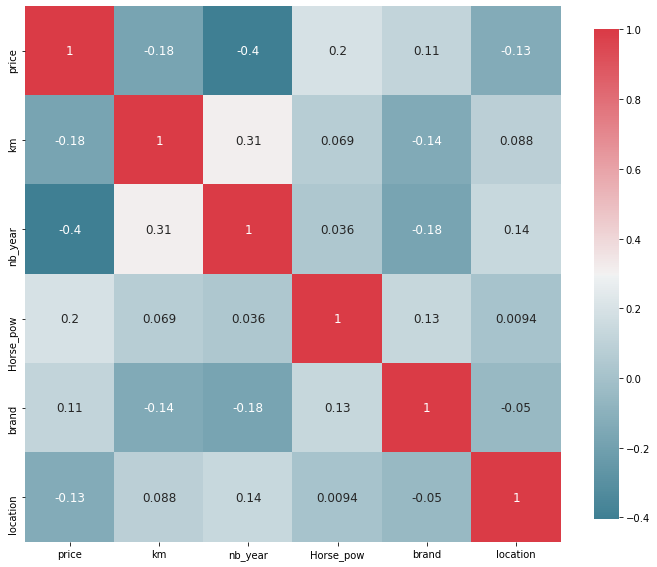

In [1032]:
num_columns=['price','km','nb_year','Horse_pow','brand','location','Fuel_Type']
plot_correlation_map(data[num_columns])

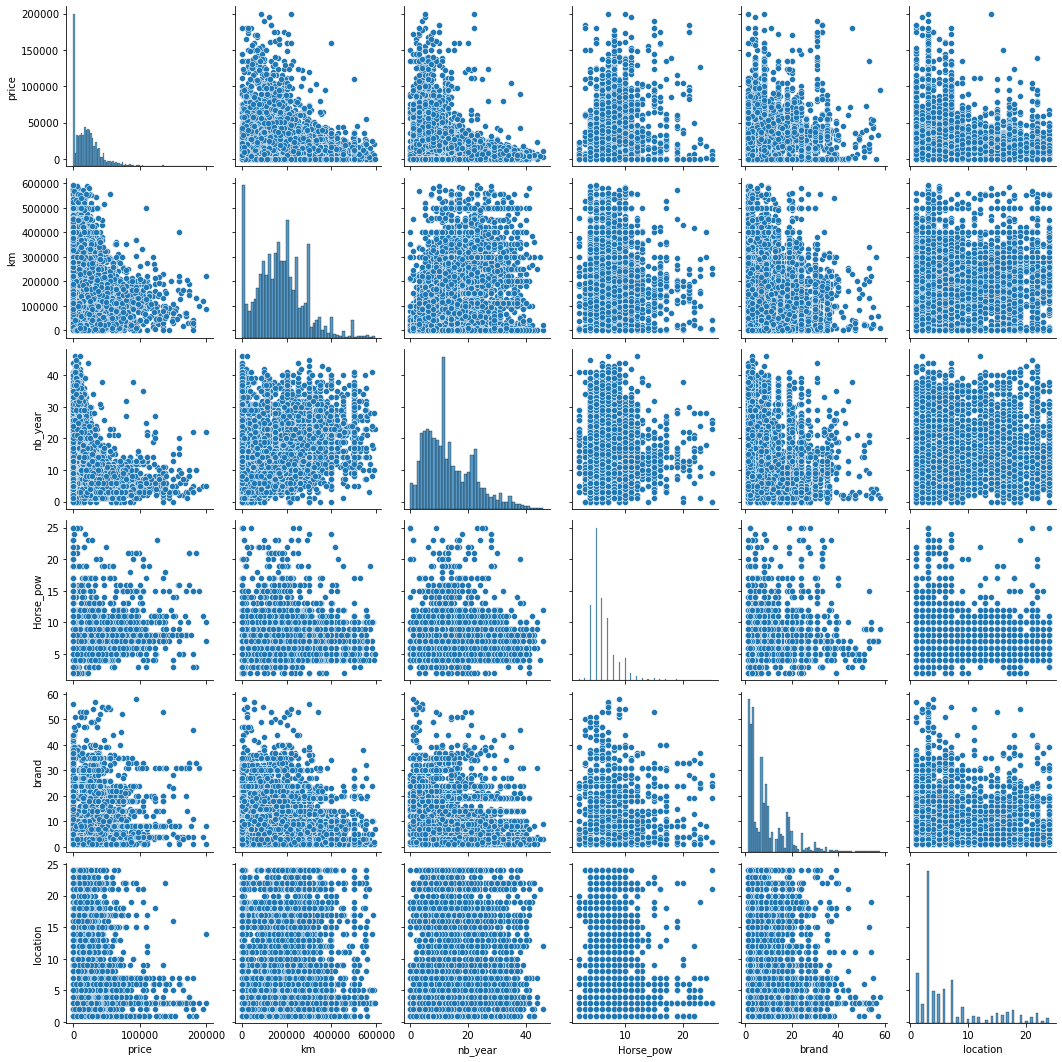

In [1033]:
sb.pairplot(data[num_columns])

Text(0, 0.5, 'count')

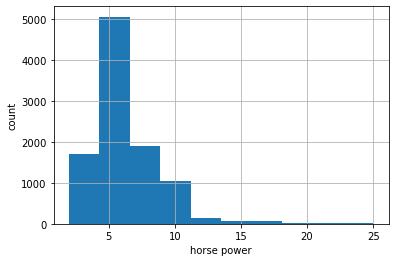

In [1034]:
data.Horse_pow.hist()
plt.xlabel('horse power')
plt.ylabel('count')

Text(0, 0.5, 'count')

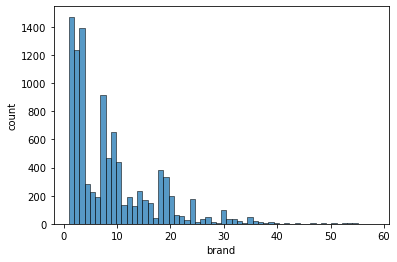

In [1035]:
Axes=sb.histplot(data.brand,bins=58)
plt.xlabel('brand')
plt.ylabel('count')


In [1036]:
target = data.price

In [1037]:
# numeric features
num_feat = data[['km','nb_year','Horse_pow','brand','location']]


# Regression Model

## Linear

In [1038]:
#feature selection
x = num_feat['nb_year'].values.reshape(-1, 1)
y = target
# Split data
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.45,random_state=40) 
# Model and degree selection
lg=LinearRegression()
# train model
lg.fit(x_train, y_train)
predicted = lg.predict(x_test)
# prediction error and fit#
RMSE = np.sqrt(metrics.mean_squared_error(y_test, predicted))
R2_lg = metrics.r2_score(y_test,predicted)
print("RMSE: ", RMSE)
print("R squared: ",R2_lg )
print("Coefficients: ", lg.coef_)
print("b: ",lg.intercept_)
print("RSR-ratio: ", RMSE/data['price'].std(axis=0)) # RSR = RMSE/StandardDev(Price) 
                                                           #the lower the better our model is

RMSE:  21717.25807909859
R squared:  0.16306057266111795
Coefficients:  [-1085.81757725]
b:  37405.11910420486
RSR-ratio:  0.9227175799404417


## Multi-linear

In [1039]:
x = num_feat.values
y = target.values

x_train,x_test,y_train,y_test = train_test_split(num_feat,target,test_size=0.45,random_state=30) 
# Model and degree selection
multi_lg=LinearRegression()
# train model
multi_lg.fit(x_train, y_train)
predicted = multi_lg.predict(x_test)
# prediction error and fit
RMSE = np.sqrt(metrics.mean_squared_error(y_test, predicted))
R2_multi_lg= metrics.r2_score(y_test,predicted)
inc = (R2_multi_lg-R2_lg)/R2_lg *100
print("RMSE: ", RMSE)
print("R squared: ",R2_multi_lg)
print("Accuracy increase: %5.2f"%(inc),'%')
print("Coefficients: ", multi_lg.coef_)
print("b: ",multi_lg.intercept_)
print("RSR-ratio: ", RMSE/data['price'].std(axis=0)) # RSR = RMSE/StandardDev(Price) 
                                                           #the lower the better our model is

RMSE:  21394.31113744592
R squared:  0.21361799302998985
Accuracy increase: 31.01 %
Coefficients:  [-1.42935593e-02 -1.03146300e+03  1.96337746e+03 -2.26895143e+01
 -3.21882850e+02]
b:  28982.174257181417
RSR-ratio:  0.9089962888195467


## Polynomial

In [1040]:
x = num_feat.values
y = target.values
# Split data
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.45,random_state=30) 
# Model and degree selection
pg=LinearRegression()
poly = PolynomialFeatures(degree=2)
# transform train and test input data
x_train_fit = poly.fit_transform(x_train) 
x_test_fit = poly.fit_transform(x_test)
# train model
pg.fit(x_train_fit, y_train)
predicted = pg.predict(x_test_fit)
# prediction error and fit
RMSE = np.sqrt(metrics.mean_squared_error(y_test, predicted))
R2_pg= metrics.r2_score(y_test,predicted)
inc = (R2_pg-R2_multi_lg)/R2_multi_lg *100
print("RMSE: ", RMSE)
print("R squared: ",R2_pg)
print("Accuracy increase: %5.2f"%(inc),'%')
print("Coefficients: ", pg.coef_)
print("b: ",pg.intercept_)
print("RSR-ratio: ", RMSE/data['price'].std(axis=0)) # RSR = RMSE/StandardDev(Price) 
                                                           #the lower the better our model is

RMSE:  20594.21951748232
R squared:  0.2713354718099379
Accuracy increase: 27.02 %
Coefficients:  [ 0.00000000e+00 -8.72715085e-03 -1.71572877e+03  7.22693641e+03
 -4.55743976e+02  4.66267796e+01 -1.03886243e-07  1.67586802e-03
  3.97779742e-04  5.79291581e-04  4.80784091e-04  2.67800895e+01
 -1.04799252e+02  1.10799604e+01  1.26258131e+01 -1.88789207e+02
  2.81715136e+01 -9.11177357e+01  2.71489818e+00 -1.38191596e+01
  1.50659730e+00]
b:  14449.293117817844
RSR-ratio:  0.875002190641289


# Random Forest

In [1041]:
feat = ['km','nb_year','Horse_pow','brand']
x = num_feat[feat].values
y = target.values
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=30) 

In [1042]:
# loop over max_depth to calculate best tree depth
score = 0
best_depth = 0
for i in range(1,20):
    DecTree = tree.DecisionTreeClassifier(max_depth=i,criterion='gini')
    DecTree.fit(x_train,y_train)
    y_pred =  DecTree.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    print('tree depth:{} '.format(i)+"score:{}".format(accuracy_score(y_test, y_pred)))
    if acc>score:
        score = acc
        best_depth = i
print(best_depth,score)

tree depth:1 score:0.0176
tree depth:2 score:0.0204
tree depth:3 score:0.0264
tree depth:4 score:0.0284
tree depth:5 score:0.0244
tree depth:6 score:0.0228
tree depth:7 score:0.0276
tree depth:8 score:0.026
tree depth:9 score:0.0272
tree depth:10 score:0.026
tree depth:11 score:0.0228
tree depth:12 score:0.0256
tree depth:13 score:0.0228
tree depth:14 score:0.0248
tree depth:15 score:0.0252
tree depth:16 score:0.0256
tree depth:17 score:0.0224
tree depth:18 score:0.026
tree depth:19 score:0.0284
4 0.0284


In [849]:
# loop over n_estimators to calculate best one
score = 0
best_n = 1
for i in range(1,100):
    RanFo = RandomForestClassifier(n_estimators=50,max_depth=best_depth)
    RanFo.fit(x_train,y_train)
    y_pred = RanFo.predict(x_test)
    acc = accuracy_score(y_test, y_pred)
    print('n:{} '.format(i)+"score:{}".format(accuracy_score(y_test, y_pred)))
    if acc>score:
        score = acc
        best_n = i
print(score,best_n)

n:1 score:0.04078368652538984
n:2 score:0.037984806077568975
n:3 score:0.040383846461415435
n:4 score:0.042782886845261894
n:5 score:0.03958416633346661
n:6 score:0.04118352658936426
n:7 score:0.03758496601359456
n:8 score:0.04118352658936426
n:9 score:0.04078368652538984
n:10 score:0.043982407037185124
n:11 score:0.040383846461415435
n:12 score:0.042782886845261894
n:13 score:0.03958416633346661
n:14 score:0.040383846461415435
n:15 score:0.04238304678128749
n:16 score:0.039184326269492205
n:17 score:0.04198320671731307
n:18 score:0.037984806077568975
n:19 score:0.03958416633346661
n:20 score:0.03998400639744103
n:21 score:0.04118352658936426
n:22 score:0.039184326269492205
n:23 score:0.04078368652538984
n:24 score:0.039184326269492205
n:25 score:0.041583366653338664
n:26 score:0.039184326269492205
n:27 score:0.042782886845261894
n:28 score:0.04078368652538984
n:29 score:0.04078368652538984
n:30 score:0.041583366653338664
n:31 score:0.03958416633346661
n:32 score:0.04358256697321072
n:

In [1043]:
RanFo = RandomForestClassifier(n_estimators=best_n,max_depth=best_depth)
RanFo.fit(x_train,y_train)
y_pred = RanFo.predict(x_test)
print("score:{}".format(accuracy_score(y_test, y_pred)))

score:0.0272
